#MNIST digit recognition using SVC and PCA with Polynomial Kernel

polynomial: ($\gamma \langle x, x'\rangle + r)^d$    

keywords ... $\gamma$: **gamma**, $d$: **degree**, $r$: **coef0**

#> Using randomized grid search, find optimal parameters

In [1]:
from __future__ import division
import os, time, math, csv
import cPickle as pickle

from operator import itemgetter
from tabulate import tabulate

import matplotlib.pyplot as plt

import numpy as np
import scipy

from print_imgs import print_imgs # my own function to print a grid of square images

from sklearn.utils            import shuffle
from sklearn.decomposition    import PCA

from sklearn.svm              import SVC

from sklearn.cross_validation import StratifiedKFold
from sklearn.cross_validation import train_test_split
from sklearn.grid_search      import RandomizedSearchCV

from sklearn.metrics          import classification_report, confusion_matrix

np.random.seed(seed=1009)

%matplotlib inline

In [2]:
#%qtconsole

##Where's the data?

In [3]:
file_path = '../data/'

DESKEWED = True
if DESKEWED:
    train_img_filename = 'train-images_deskewed.csv'
    test_img_filename  = 't10k-images_deskewed.csv'
else:
    train_img_filename = 'train-images.csv'
    test_img_filename  = 't10k-images.csv'
    
train_label_filename   = 'train-labels.csv'
test_label_filename    = 't10k-labels.csv'

##How much of the data will we use?

In [22]:
portion = 0.2  # set to 1.0 for all of it, less than 1.0 for less

##Read the training images and labels

In [5]:
# read trainX
with open(file_path + train_img_filename,'r') as f:
    data_iter = csv.reader(f, delimiter = ',')
    data      = [data for data in data_iter]
trainX = np.ascontiguousarray(data, dtype = np.float64)  

# read trainY
with open(file_path + train_label_filename,'r') as f:
    data_iter = csv.reader(f, delimiter = ',')
    data      = [data for data in data_iter]
trainY = np.ascontiguousarray(data, dtype = np.int8).ravel() 
    
# shuffle trainX & trainY
trainX, trainY = shuffle(trainX, trainY, random_state=0)

# select a subset if asked
if portion < 1.0:
    trainX = trainX[:portion*trainX.shape[0]]
    trainY = trainY[:portion*trainY.shape[0]]

print("trainX shape: {0}".format(trainX.shape))
print("trainY shape: {0}\n".format(trainY.shape))

print(trainX.flags)

trainX shape: (6000, 784)
trainY shape: (6000,)

  C_CONTIGUOUS : True
  F_CONTIGUOUS : False
  OWNDATA : False
  WRITEABLE : True
  ALIGNED : True
  UPDATEIFCOPY : False


##Read the test images and labels

In [6]:
# read testX
with open(file_path + test_img_filename,'r') as f:
    data_iter = csv.reader(f, delimiter = ',')
    data      = [data for data in data_iter]
testX = np.ascontiguousarray(data, dtype = np.float64)  

# read testY
with open(file_path + test_label_filename,'r') as f:
    data_iter = csv.reader(f, delimiter = ',')
    data      = [data for data in data_iter]
testY = np.ascontiguousarray(data, dtype = np.int8).ravel()

# shuffle testX, testY
testX, testY = shuffle(testX, testY, random_state=0)

# select a subset if asked
if portion < 1.0:
    testX = testX[:portion*testX.shape[0]]
    testY = testY[:portion*testY.shape[0]]

print("testX shape: {0}".format(testX.shape))
print("testY shape: {0}".format(testY.shape))

testX shape: (1000, 784)
testY shape: (1000,)


#Use the smaller, fewer images for testing

##Print a sample

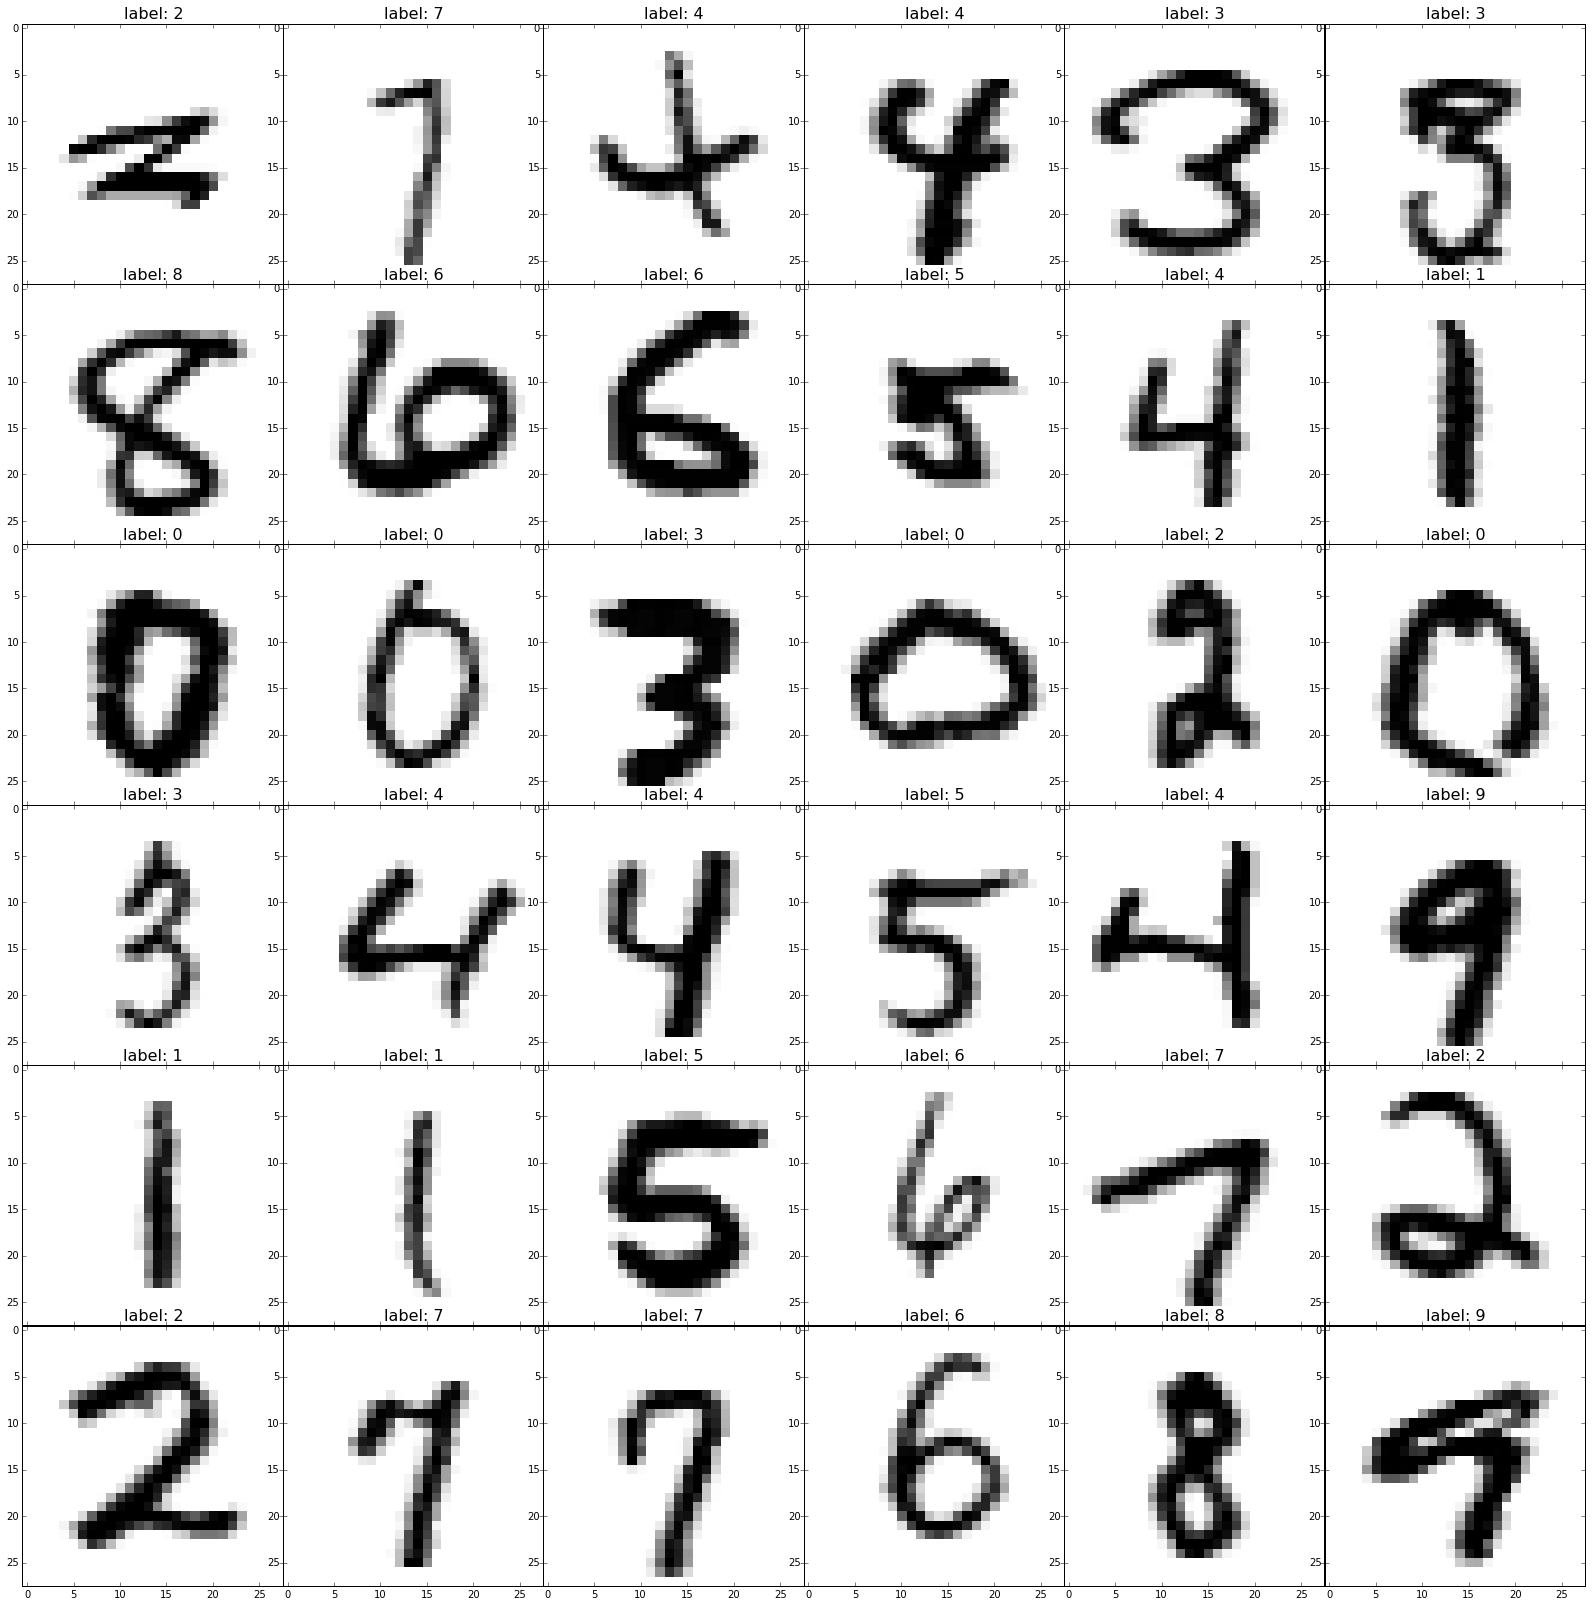

In [7]:
print_imgs(images           = trainX, 
           actual_labels    = trainY, 
           predicted_labels = trainY,
           starting_index   = np.random.randint(0, high=trainY.shape[0]-36, size=1)[0],
           size             = 6)

#Singular Value Decomposition analysis

In [8]:
t0 = time.time()

S = scipy.linalg.svd(trainX, compute_uv=False)

pctvar = np.cumsum((S**2)/np.sum(S**2))  # proportion of variance
pct80 = next(x[0] for x in enumerate(pctvar) if x[1] > 0.80)-1
pct85 = next(x[0] for x in enumerate(pctvar) if x[1] > 0.85)-1
pct90 = next(x[0] for x in enumerate(pctvar) if x[1] > 0.90)-1
pct95 = next(x[0] for x in enumerate(pctvar) if x[1] > 0.95)-1
pct99 = next(x[0] for x in enumerate(pctvar) if x[1] > 0.99)-1

S = None

print("\ntime in minutes {0:.2f}".format((time.time()-t0)/60))


time in minutes 0.00


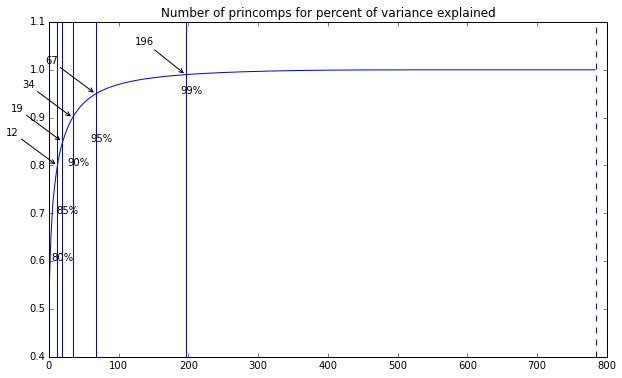

In [9]:
fig = plt.figure(figsize=(10,6))
ax  = fig.add_subplot(111)
plt.title("Number of princomps for percent of variance explained")
plt.axvline(x=pct80)
plt.axvline(x=pct85)
plt.axvline(x=pct90)
plt.axvline(x=pct95)
plt.axvline(x=pct99)
plt.axvline(x=trainX.shape[1],linestyle="--")
plt.plot(pctvar)

x1,x2,y1,y2 = plt.axis()
plt.axis((x1, x2, 0.4, 1.1))

ax.annotate(str(pct80), xy=(pct80, 0.8),  xycoords='data',
                xytext=(-50, 30), textcoords='offset points',
                arrowprops=dict(arrowstyle="->")
                )
ax.annotate("80%", xy=(pct80, 0.6),  xycoords='data',
                xytext=(-5, 0), textcoords='offset points')

ax.annotate(str(pct85), xy=(pct85, 0.85),  xycoords='data',
                xytext=(-50, 30), textcoords='offset points',
                arrowprops=dict(arrowstyle="->")
                )
ax.annotate("85%", xy=(pct85, 0.7),  xycoords='data',
                xytext=(-5, 0), textcoords='offset points')
                
ax.annotate(str(pct90), xy=(pct90, 0.9),  xycoords='data',
                xytext=(-50, 30), textcoords='offset points',
                arrowprops=dict(arrowstyle="->")
                )
ax.annotate("90%", xy=(pct90, 0.80),  xycoords='data',
                xytext=(-5, 0), textcoords='offset points')

ax.annotate(str(pct95), xy=(pct95, 0.95),  xycoords='data',
                xytext=(-50, 30), textcoords='offset points',
                arrowprops=dict(arrowstyle="->")
                )
ax.annotate("95%", xy=(pct95, 0.85),  xycoords='data',
                xytext=(-5, 0), textcoords='offset points')

ax.annotate(str(pct99), xy=(pct99, 0.99),  xycoords='data',
                xytext=(-50, 30), textcoords='offset points',
                arrowprops=dict(arrowstyle="->")
                )
ax.annotate("99%", xy=(pct99, 0.95),  xycoords='data',
                xytext=(-5, 0), textcoords='offset points')

plt.show()

In [10]:
table=[[80,pct80, pct80/trainX.shape[1]*100, (1-pct80/trainX.shape[1])*100],
       [85,pct85, pct85/trainX.shape[1]*100, (1-pct85/trainX.shape[1])*100],
       [90,pct90, pct90/trainX.shape[1]*100, (1-pct90/trainX.shape[1])*100],
       [95,pct95, pct95/trainX.shape[1]*100, (1-pct95/trainX.shape[1])*100],
       [99,pct99, pct99/trainX.shape[1]*100, (1-pct99/trainX.shape[1])*100]]
print tabulate(np.round(table), headers=["Pct Variance","Princomps","Percent", "Pct Reduction"])

  Pct Variance    Princomps    Percent    Pct Reduction
--------------  -----------  ---------  ---------------
            80           12          2               98
            85           19          2               98
            90           34          4               96
            95           67          9               91
            99          196         25               75


#PCA dimensionality reduction

In [11]:
pca = PCA(n_components=0.85, whiten=True)

trainX = pca.fit_transform(trainX)
testX  = pca.transform(testX)

print("trainX shape: {0}".format(trainX.shape))
print("trainY shape: {0}\n".format(trainY.shape))
print("testX shape: {0}".format(testX.shape))
print("testY shape: {0}".format(testY.shape))

trainX shape: (6000, 44)
trainY shape: (6000,)

testX shape: (1000, 44)
testY shape: (1000,)


#SVC Default Parameter Settings

In [12]:
# default parameters for SVC
# ==========================
default_svc_params = {}

default_svc_params['C']            = 1.0      # penalty
default_svc_params['class_weight'] = None     # Set the parameter C of class i to class_weight[i]*C
                                              # set to 'auto' for unbalanced classes
default_svc_params['gamma']        = 0.0      # Kernel coefficient for 'rbf', 'poly' and 'sigmoid'

default_svc_params['kernel']       = 'rbf'    # 'linear', 'poly', 'rbf', 'sigmoid', 'precomputed' or a callable 
default_svc_params['shrinking']    = True     # Whether to use the shrinking heuristic.     
default_svc_params['probability']  = False    # Whether to enable probability estimates.    
default_svc_params['tol']          = 0.001    # Tolerance for stopping criterion. 
default_svc_params['cache_size']   = 200      # size of the kernel cache (in MB).

default_svc_params['max_iter']     = -1       # limit on iterations within solver, or -1 for no limit. 
   
default_svc_params['verbose']      = False 
default_svc_params['degree']       = 3        # 'poly' only
default_svc_params['coef0']        = 0.0      # 'poly' and 'sigmoid' only

# set parameters for the estimator
svc_params = dict(default_svc_params)

svc_params['cache_size'] = 2000
svc_params['probability'] = True

svc_params['kernel']     = 'poly'
svc_params['C']          = 1.0
svc_params['gamma']      = 0.0
svc_params['degree']     = 3
svc_params['coef0']      = 1

# the classifier
svc_clf = SVC(**svc_params)

##RANDOMIZED grid search

In [13]:
t0 = time.time()

# search grid
# ===========
search_grid = dict(C      = np.logspace(-1,  4, 50),
                   gamma  = np.logspace(-3,  0, 50),
                   degree = [2, 3, 4, 5, 6, 7, 8, 9])

# stratified K-Fold indices
# =========================
SKFolds = StratifiedKFold(y            = trainY, 
                          n_folds      = 5, 
                          indices      = None) 

# default parameters for RandomizedSearchCV
# =========================================
default_random_params = {}
default_random_params['scoring']      = None            
default_random_params['fit_params']   = None      # dict of parameters to pass to the fit method
default_random_params['n_jobs']       = 1         
default_random_params['pre_dispatch'] = '2*n_jobs' # memory is copied this many times
                                                   # reduce if you're running into memory problems
    
default_random_params['iid']          = True       # assume the folds are iid 
default_random_params['refit']        = True       # Refit the best estimator with the entire dataset 
default_random_params['cv']           = None 
default_random_params['verbose']      = 0 
default_random_params['n_iter']       = 10

# set parameters for the randomized grid search
# =============================================
random_params = dict(default_random_params)

random_params['verbose']      = 1
random_params['cv']           = SKFolds 
random_params['n_jobs']       = -1                # -1 => use all available cores
                                                  #       one core per fold
                                                  #       for each point in the grid

random_params['n_iter']       = 100               # choose this many random combinations of parameters
                                                  # from the 'search_grid'


# perform the randomized parameter grid search
# ============================================
random_search = RandomizedSearchCV(estimator           = svc_clf, 
                                   param_distributions = search_grid, 
                                   **random_params)

random_search.fit(trainX, trainY)

# ===========================
# save the classifier to disk
# ===========================
pickle.dump(random_search, open('SVC_POLY_PCA.pkl', 'wb'))

print("\ntime in minutes {0:.2f}".format((time.time()-t0)/60))

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Done   1 jobs       | elapsed:    3.6s
[Parallel(n_jobs=-1)]: Done  50 jobs       | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 200 jobs       | elapsed:  4.0min
[Parallel(n_jobs=-1)]: Done 450 jobs       | elapsed:  9.8min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed: 10.7min finished



time in minutes 10.81


##Analyze the results of the parameter pairs randomly selected

In [15]:
# =================================
# retrieve the classifier from disk
# =================================
random_search = None
random_search = pickle.load(open('SVC_POLY_PCA.pkl', 'rb'))

from collections import Counter
from operator    import itemgetter

# how many duds?
# ==============
mean_score_list = [score.mean_validation_score for score in random_search.grid_scores_]
print("\nProportion of random scores below 98%: {0:.2f}\n".format(sum(np.array(mean_score_list)<0.98)/len(mean_score_list)))

# what do the best ones look like?
for score in sorted(random_search.grid_scores_, key=itemgetter(1), reverse=True)[:10]:
    print score

    # find the most-common coef0 and degree among the top ten 
# =======================================================
random_search.grid_scores_.sort(reverse=True, key=itemgetter(1)) # descending mean score

#coef0_s  = []
degree_s = []
for score in random_search.grid_scores_[:10]:
    print score
    #coef0_s.append(score.parameters['coef0'])
    degree_s.append(score.parameters['degree'])
    
most_common_degree = Counter(degree_s).most_common()[0][0]
#most_common_coef0  = Counter(coef0_s).most_common()[0][0]
print ("\nmost-common top-10 degree: {0}; coef0: {1}".format(most_common_degree, 1))


Proportion of random scores below 98%: 1.00

mean: 0.97283, std: 0.00418, params: {'C': 2.5595479226995357, 'degree': 3, 'gamma': 0.059636233165946427}
mean: 0.97117, std: 0.00367, params: {'C': 33.932217718953297, 'degree': 4, 'gamma': 0.033932217718953266}
mean: 0.97117, std: 0.00222, params: {'C': 568.98660290182988, 'degree': 4, 'gamma': 0.071968567300115138}
mean: 0.97083, std: 0.00254, params: {'C': 79060.43210907701, 'degree': 4, 'gamma': 0.059636233165946427}
mean: 0.97083, std: 0.00254, params: {'C': 109.85411419875584, 'degree': 4, 'gamma': 0.059636233165946427}
mean: 0.97050, std: 0.00296, params: {'C': 3.2374575428176442, 'degree': 5, 'gamma': 0.015998587196060572}
mean: 0.97050, std: 0.00296, params: {'C': 12067.92640639329, 'degree': 5, 'gamma': 0.015998587196060572}
mean: 0.97017, std: 0.00307, params: {'C': 910.29817799152181, 'degree': 3, 'gamma': 0.26826957952797248}
mean: 0.97000, std: 0.00377, params: {'C': 222.29964825261956, 'degree': 5, 'gamma': 0.02811768697974

##Heatmap of the accuracy of the C and gamma pairs chosen in the grid search

see http://scikit-learn.org/stable/auto_examples/svm/plot_rbf_parameters.html

This script was extensively modified to work with the score results from **RandomizedSearchCV**

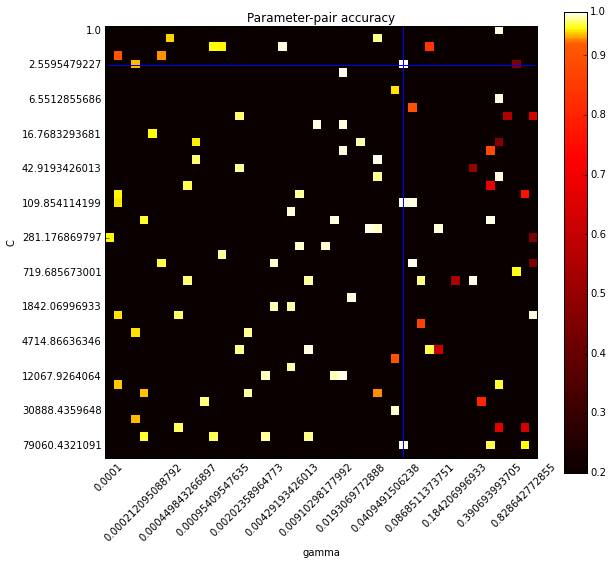


The best parameters are {'C': 2.5595479226995357, 'degree': 3, 'gamma': 0.059636233165946427}
with a score of 0.97, misclass of 0.0272


In [16]:
from matplotlib.colors import Normalize

class MidpointNormalize(Normalize):
    """Utility function to move the midpoint of a colormap to be around the values of interest."""

    def __init__(self, vmin=None, vmax=None, midpoint=None, clip=False):
        self.midpoint = midpoint
        Normalize.__init__(self, vmin, vmax, clip)

    def __call__(self, value, clip=None):
        x, y = [self.vmin, self.midpoint, self.vmax], [0, 0.5, 1]
        return np.ma.masked_array(np.interp(value, x, y))
    
# --------------------------------------------------------------------------------

# skip this many parameter values on the display axes
tick_step_size_C     = math.ceil(len(search_grid['C']) / 15)  
tick_step_size_gamma = math.ceil(len(search_grid['gamma']) / 15)
    
# create 'heatmap'
# ================

# a C x gamma matrix; initially all zeros (black)
heatmap = np.zeros((len(search_grid['C']), len(search_grid['gamma'])))

# for each score, find the index in 'heatmap' of the 'C' and 'gamma' values
# at that index intersection put the mean score
for score in random_search.grid_scores_:
    # index of C and gamma in 'search_grid'
    ceeinx = search_grid['C'].tolist().index(score[0]['C'])
    gaminx = search_grid['gamma'].tolist().index(score[0]['gamma'])
    heatmap[ceeinx, gaminx] = score[1]


# display the heatmap
# ===================
plt.figure(figsize=(10, 8))
plt.subplots_adjust(left=.2, right=0.95, bottom=0.15, top=0.95)

plt.imshow(heatmap, interpolation='nearest', cmap=plt.cm.hot,
           norm=MidpointNormalize(vmin=0.2, midpoint=0.92))
plt.xlabel('gamma')
plt.ylabel('C')

plt.colorbar()

# label the axes
plt.xticks(np.arange(0, len(search_grid['gamma']), tick_step_size_gamma), 
           search_grid['gamma'][::tick_step_size_gamma], 
           rotation=45)

plt.yticks(np.arange(0, len(search_grid['C']), tick_step_size_C), 
           search_grid['C'][::tick_step_size_C])

# cross hairs
ceeinx = search_grid['C'].tolist().index(random_search.best_params_['C'])
plt.axhline(y=ceeinx)
gaminx = search_grid['gamma'].tolist().index(random_search.best_params_['gamma'])
plt.axvline(x=gaminx)

plt.title('Parameter-pair accuracy')
plt.show()

print("\nThe best parameters are %s\nwith a score of %0.2f, misclass of %0.4f"
      % (random_search.best_params_, random_search.best_score_, 1-random_search.best_score_))

#Predict the test set and analyze the result

In [17]:
target_names     = ["0", "1", "2", "3", "4", "5", "6", "7", "8", "9"]

predicted_values = random_search.predict(testX)
y_true, y_pred   = testY, predicted_values

print(classification_report(y_true, y_pred, target_names=target_names))

             precision    recall  f1-score   support

          0       0.98      0.98      0.98        96
          1       0.99      0.99      0.99       118
          2       0.99      1.00      0.99        90
          3       1.00      0.97      0.99       104
          4       0.97      0.93      0.95       122
          5       0.95      0.99      0.97        87
          6       0.96      0.98      0.97        91
          7       0.98      0.98      0.98        98
          8       0.98      0.97      0.97        92
          9       0.95      0.97      0.96       102

avg / total       0.98      0.97      0.97      1000



[[ 94   0   0   0   0   0   2   0   0   0]
 [  0 117   0   0   0   0   1   0   0   0]
 [  0   0  90   0   0   0   0   0   0   0]
 [  0   0   0 101   0   2   0   1   0   0]
 [  1   0   1   0 114   0   1   0   1   4]
 [  0   0   0   0   0  86   0   0   1   0]
 [  1   0   0   0   0   1  89   0   0   0]
 [  0   1   0   0   1   0   0  96   0   0]
 [  0   0   0   0   1   1   0   0  89   1]
 [  0   0   0   0   1   1   0   1   0  99]]

Model accuracy: 0.975, model misclass rate: 0.025


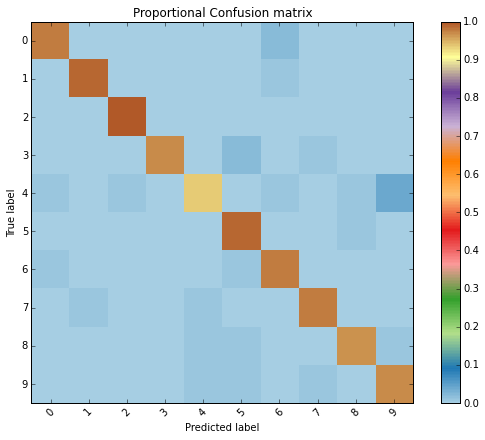

In [18]:
def plot_confusion_matrix(cm, 
                          target_names,
                          title='Proportional Confusion matrix', 
                          cmap=plt.cm.Paired):  
    """
    given a confusion matrix (cm), make a nice plot
    see the skikit-learn documentation for the original done for the iris dataset
    """
    plt.figure(figsize=(8, 6))
    plt.imshow((cm/cm.sum(axis=1)), interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(target_names))
    plt.xticks(tick_marks, target_names, rotation=45)
    plt.yticks(tick_marks, target_names)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
# --------------------------------------------------------------------------------------------
    
cm = confusion_matrix(y_true, y_pred)  

print(cm)
model_accuracy = sum(cm.diagonal())/len(testY)
model_misclass = 1 - model_accuracy
print("\nModel accuracy: {0}, model misclass rate: {1}".format(model_accuracy, model_misclass))

plot_confusion_matrix(cm, target_names)

##Learning Curves

see http://scikit-learn.org/stable/auto_examples/model_selection/plot_learning_curve.html

The red line shows how well we fit the training data. The larger the score, the lower the bias. We expect the red line to start very near to 1.0 since we ought to be able to fit just a few points very well. We expect the red line to decline slightly since more points to fit requires a more complex model.

The green line shows the accuracy of the predictions of the test set. We expect it to start much lower than the red line but to increase continuously as the amount of training data used to create the model grows. An appropriate algorithm, correctly parameterized should push the green line higher and higher as we train with more training data. The best case is for the red line to decline only very slightly from 1.0 and for the green line to rise to intersect the red line.

A red line that starts below 1.0 and/or declines steeply indicates bias, a model that does not even fit the data it already knows the answer for. In addition to reviewing whether the algorithm is appropriate and whether it is optimally parameterized you may consider ways to increase the number of useful predictor variables.

A red line that hugs the top but for which the green line does not rise to meet it indicates overfitting.

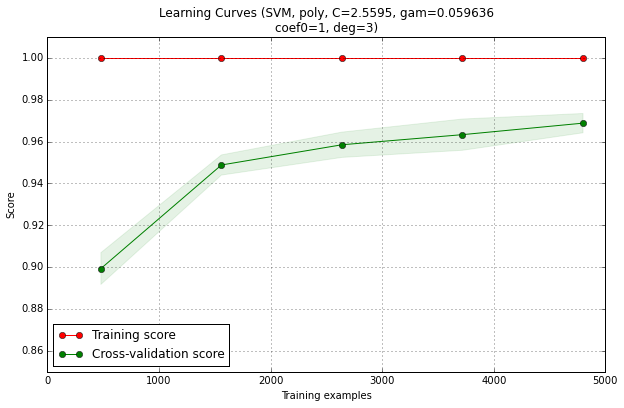


time in minutes 0.19


In [21]:
t0 = time.time()

from sklearn.learning_curve   import learning_curve
from sklearn.cross_validation import ShuffleSplit


def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5)):
    """
    Generate a simple plot of the test and training learning curve.

    Parameters
    ----------
    estimator : object type that implements the "fit" and "predict" methods
        An object of that type which is cloned for each validation.

    title : string
        Title for the chart.

    X : array-like, shape (n_samples, n_features)
        Training vector, where n_samples is the number of samples and
        n_features is the number of features.

    y : array-like, shape (n_samples) or (n_samples, n_features), optional
        Target relative to X for classification or regression;
        None for unsupervised learning.

    ylim : tuple, shape (ymin, ymax), optional
        Defines minimum and maximum yvalues plotted.

    cv : integer, cross-validation generator, optional
        If an integer is passed, it is the number of folds (defaults to 3).
        Specific cross-validation objects can be passed, see
        sklearn.cross_validation module for the list of possible objects

    n_jobs : integer, optional
        Number of jobs to run in parallel (default 1).
    """
    plt.figure(figsize=(10, 6))
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std  = np.std(train_scores, axis=1)
    
    test_scores_mean  = np.mean(test_scores, axis=1)
    test_scores_std   = np.std(test_scores, axis=1)
    
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

# --------------------------------------------------------------------------------

C_gamma = "C="       + str(np.round(random_search.best_params_['C'],4))      + \
          ", gam="   + str(np.round(random_search.best_params_['gamma'],6))  + \
        "\ncoef0=" + str(1)  + \
          ", deg="   + str(np.round(random_search.best_params_['degree'],0))

plot_learning_curve(estimator = random_search.best_estimator_, 
                    title     = "Learning Curves (SVM, poly, " + C_gamma + ")", 
                    X         = trainX, 
                    y         = trainY.ravel(), 
                    ylim      = (0.85, 1.01), 
                    cv        = ShuffleSplit(n            = trainX.shape[0], 
                                             n_iter       = 5, 
                                             test_size    = 0.2, 
                                             random_state = 0), 
                    n_jobs    = 8)

plt.show()

print("\ntime in minutes {0:.2f}".format((time.time()-t0)/60))

##Validation Curves


The best parameters chosen were {'C': 2.5595479226995357, 'degree': 3, 'gamma': 0.059636233165946427}
with a score of 0.97, misclass of 0.0272


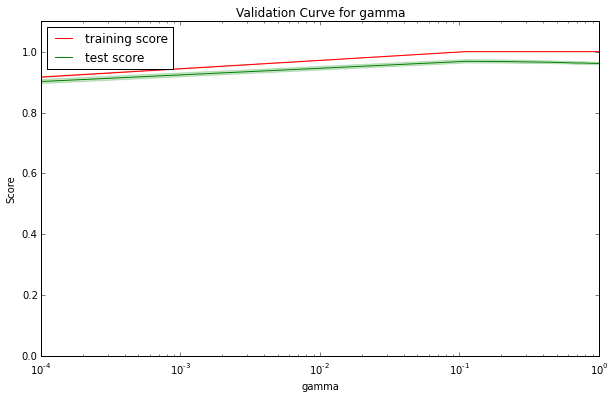

1
Best gamma holding the others constant 0.1112; range [0.0001, 1.0]


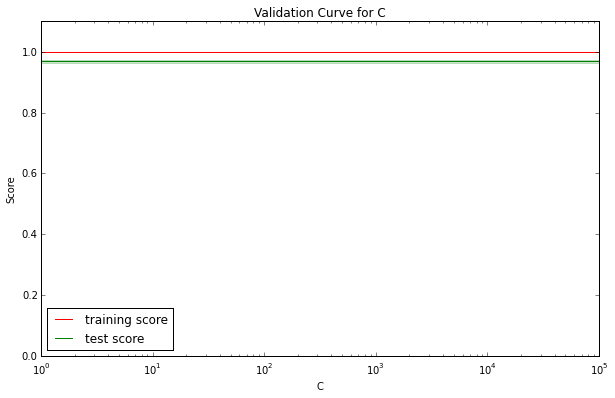

0
Best C holding the others constant 1.0; range [1.0, 100000.0]


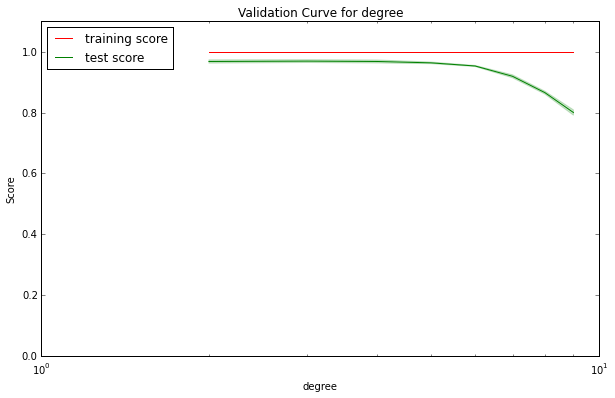

1
Best degree holding the others constant 3; range [2, 9]

time in minutes 3.51


In [27]:
t0 = time.time()

print("\nThe best parameters chosen were %s\nwith a score of %0.2f, misclass of %0.4f"
      % (random_search.best_params_, random_search.best_score_, 1-random_search.best_score_))

from sklearn.learning_curve   import validation_curve
from sklearn.cross_validation import ShuffleSplit


for param_name, param_range in zip(["gamma","C","degree"], 
                                   [np.linspace(search_grid['gamma'][0],search_grid['gamma'][-1],10), 
                                    np.linspace(search_grid['C'][0],search_grid['C'][-1],10),
                                    search_grid['degree']]):

    train_scores, test_scores = validation_curve(estimator   = random_search.best_estimator_,
                                                 X           = trainX,
                                                 y           = trainY,
                                                 param_name  = param_name,
                                                 param_range = param_range,
                                                 cv = ShuffleSplit(n            = trainX.shape[0], 
                                                                   n_iter       = 5, 
                                                                   test_size    = 0.2, 
                                                                   random_state = 0),
                                                 scoring      = 'accuracy',
                                                 n_jobs       = -1,
                                                 pre_dispatch = '2*n_jobs',
                                                 verbose      = 0)

    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std  = np.std(train_scores, axis=1)
    test_scores_mean  = np.mean(test_scores, axis=1)
    test_scores_std   = np.std(test_scores, axis=1)

    plt.figure(figsize=(10,6))
    plt.title("Validation Curve for " + param_name)
    
    plt.xlabel(param_name)
    plt.ylabel("Score")
    plt.ylim(0.0, 1.1)

    plt.semilogx(param_range,
                 train_scores_mean,
                 label="training score", color="r")
    plt.fill_between(param_range,
                     train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std,
                     alpha=0.2, color="r")

    plt.semilogx(param_range,
                 test_scores_mean,
                 label="test score", color="g")
    plt.fill_between(param_range,
                     test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std,
                     alpha=0.2, color="g")

    plt.legend(loc="best")
    plt.show()
    print("Best {0} holding the others constant {1}; range [{2}, {3}]".format(param_name, 
                                                                              param_range[np.argmax(test_scores_mean)],
                                                                             np.min(param_range),
                                                                             np.max(param_range)))


print("\ntime in minutes {0:.2f}".format((time.time()-t0)/60))      